In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm import tqdm, tqdm_notebook, trange
from scipy.optimize import fmin
from pylab import rcParams
from IPython.display import clear_output
import copy
rcParams['figure.figsize'] = 8, 5

C:\Users\shankar\Anaconda3\envs\tf\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Imports for better visualization
from matplotlib import rcParams
#colorbrewer2 Dark2 qualitative color table
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

rcParams['figure.figsize'] = (10, 4)
rcParams['figure.dpi'] = 150
#rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['font.size'] = 8
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'StixGeneral'
rcParams['axes.grid'] = True
rcParams['axes.facecolor'] = '#eeeeee'

In [3]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [4]:
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.neural_network import MLPClassifier

In [5]:
train1 = pd.read_csv('train_136_feat.csv')
test1 = pd.read_csv('test_136_feat.csv')
sample = pd.read_excel('sample_submission.xlsx')
train1.shape, test1.shape, sample.shape

((33908, 137), (11303, 136), (11303, 1))

In [6]:
train2 = pd.read_csv('train_47_feat.csv')
test2 = pd.read_csv('test_47_feat.csv')

train2.shape, test2.shape, sample.shape

((33908, 48), (11303, 47), (11303, 1))

In [7]:
cols = ['sum_num_1', 'sum_num_2', 'sum_num_3',
       'sum_cat1', 'sum_cat2', 'sum_cat3', 'sum_cat4', 'mean_num_1',
       'mean_num_2', 'mean_num_3', 'std_num_1', 'std_num_2', 'std_num_3',
       'feature_0_div_feature_1', 'feature_0_div_feature_3',
       'feature_0_div_feature_5', 'feature_1_div_feature_0',
       'feature_1_div_feature_3', 'feature_1_div_feature_5',
       'feature_3_div_feature_0', 'feature_3_div_feature_1',
       'feature_3_div_feature_5', 'feature_5_div_feature_0',
       'feature_5_div_feature_1', 'feature_5_div_feature_3',
       'feature_2_div_feature_4', 'feature_2_div_feature_6',
       'feature_4_div_feature_2', 'feature_4_div_feature_6',
       'feature_6_div_feature_2', 'feature_6_div_feature_4']

In [8]:
train = pd.concat([train1, train2[cols]], axis=1)
test = pd.concat([test1, test2[cols]], axis=1)

train.shape, test.shape

((33908, 168), (11303, 167))

In [9]:
train.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_3_div_feature_5,feature_5_div_feature_0,feature_5_div_feature_1,feature_5_div_feature_3,feature_2_div_feature_4,feature_2_div_feature_6,feature_4_div_feature_2,feature_4_div_feature_6,feature_6_div_feature_2,feature_6_div_feature_4
0,-0.276515,-0.424429,1.344997,-0.012283,0.076230,1.076648,0.182198,3.0,0.0,1.0,...,-0.011408,-3.893637,-2.536697,-87.656218,17.643945,7.382081,0.056677,0.418392,0.135463,2.390105
1,0.853573,0.150991,0.503892,-0.979179,-0.569351,-0.411453,-0.251940,4.0,1.0,2.0,...,2.379807,-0.482036,-2.725013,0.420202,-0.885029,-2.000044,-1.129907,2.259863,-0.499989,0.442505
2,0.947747,-0.173832,1.825628,-0.703478,0.076230,-0.411453,-0.251940,6.0,1.0,2.0,...,1.709740,-0.434138,2.366958,0.584884,23.948968,-7.246272,0.041755,-0.302571,-0.138002,-3.305005
3,0.853573,-0.381404,0.984523,-0.039464,-0.569351,-0.411453,-0.251940,4.0,0.0,2.0,...,0.095915,-0.482036,1.078786,10.425919,-1.729204,-3.907763,-0.578301,2.259863,-0.255901,0.442505
4,1.324443,1.590527,-1.178318,-0.097711,-0.246560,-0.411453,-0.251940,0.0,1.0,1.0,...,0.237478,-0.310661,-0.258690,4.210909,4.779027,4.676974,0.209248,0.978646,0.213813,1.021820


In [10]:
X = train.drop('labels', axis=1)
test_X = test.copy()
y = train['labels']

In [12]:
sel_1 = ['feature_0', 'feature_2', 'feature_3', 'feature_5', 'feature_11',
       'feature_13', 'feature_14', 'feature_15', 'feature_0_feature_6',
       'feature_3_feature_5', 'feature_3_feature_11', 'feature_3_feature_13',
       'feature_3_feature_14', 'feature_3_feature_15', 'feature_4_feature_9',
       'feature_4_feature_15', 'feature_5_feature_11', 'feature_5_feature_13',
       'feature_5_feature_14', 'feature_5_feature_15', 'feature_6_feature_11',
       'feature_6_feature_13', 'feature_6_feature_14', 'feature_6_feature_15',
       'feature_8_feature_13', 'feature_9_feature_13', 'feature_9_feature_14',
       'feature_9_feature_15', 'feature_11_feature_14',
       'feature_11_feature_15', 'feature_13_feature_14',
       'feature_14_feature_15', 'sum_num_1', 'sum_cat2', 'mean_num_1',
       'feature_5_div_feature_3']

In [1]:
imps_2 = ['feature_2_feature_14',
 'feature_0_div_feature_1',
 'std_num_3',
 'feature_1_feature_2',
 'feature_1_feature_9',
 'std_num_2',
 'feature_3_feature_4',
 'feature_4_div_feature_2',
 'feature_1_div_feature_3',
 'feature_3_div_feature_1',
 'feature_0_div_feature_3',
 'std_num_1',
 'feature_2_div_feature_4',
 'feature_0_feature_4',
 'feature_0_feature_7',
 'feature_3_feature_7',
 'feature_0_feature_9',
 'feature_4_feature_14',
 'feature_0_feature_8',
 'feature_2_feature_3',
 'feature_2_feature_9',
 'feature_0_div_feature_5',
 'feature_6_div_feature_2',
 'feature_3_feature_8',
 'feature_3_feature_9',
 'feature_7_feature_14']

In [19]:
len(sel_1)

36

In [20]:
len(sel_1+imps_2[:20])

56

In [21]:
len(set(sel_1+imps_2[:20]))

56

In [22]:
feats = sel_1+imps_2[:5]

In [23]:
X = X[feats]
test_X = test_X[feats]

X.shape, test_X.shape

((33908, 41), (11303, 41))

In [24]:
import os
os.mkdir('Final_Down_FES_6')
path = 'Final_Down_FES_6/'

In [25]:
from sklearn.ensemble import VotingClassifier
from catboost import CatBoostClassifier

In [26]:
param = {'objective': 'binary',
#          'num_class': 7,
         'boosting': 'gbdt',  
         'learning_rate': 0.01, 
         'num_iterations': 2000,
         'num_leaves': 100,
         'max_depth': 6,
         'min_data_in_leaf': 15,
         'bagging_fraction':0.9,
         'bagging_freq': 1,
         'feature_fraction': 0.7,
         'lambda_l2': 0.8,
         'min_data_per_group': 75,
         'max_bin': 255,
         'scale_pos_weight':3
         }

In [27]:
cat_model = CatBoostClassifier(
                         depth=6,
                         random_seed=42, 
                         iterations=1000, 
                         learning_rate=0.07,
                         leaf_estimation_iterations=1,
                         l2_leaf_reg=1, 
                         bootstrap_type='Bayesian', 
                         bagging_temperature=1, 
                         random_strength=1,
                         od_type='Iter', 
                         od_wait=200,
                         class_weights=[1,3])

lgb_model = LGBMClassifier(**param, seed=29)

xgb_model = XGBClassifier(learning_rate=0.1, n_estimators=250, max_depth=5, min_child_weight=5, 
                  gamma=0.4,nthread=4, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic',
                    scale_pos_weight=3,
                    seed=29)

0:	learn: 0.6623285	total: 132ms	remaining: 2m 11s
1:	learn: 0.6344996	total: 155ms	remaining: 1m 17s
2:	learn: 0.6085329	total: 177ms	remaining: 58.8s
3:	learn: 0.5862209	total: 201ms	remaining: 50.1s
4:	learn: 0.5667899	total: 223ms	remaining: 44.3s
5:	learn: 0.5492273	total: 245ms	remaining: 40.5s
6:	learn: 0.5323321	total: 269ms	remaining: 38.1s
7:	learn: 0.5173020	total: 292ms	remaining: 36.2s
8:	learn: 0.5032857	total: 307ms	remaining: 33.8s
9:	learn: 0.4918169	total: 319ms	remaining: 31.6s
10:	learn: 0.4807799	total: 333ms	remaining: 29.9s
11:	learn: 0.4709774	total: 343ms	remaining: 28.2s
12:	learn: 0.4618745	total: 354ms	remaining: 26.9s
13:	learn: 0.4532724	total: 370ms	remaining: 26.1s
14:	learn: 0.4457160	total: 382ms	remaining: 25.1s
15:	learn: 0.4388076	total: 391ms	remaining: 24.1s
16:	learn: 0.4323397	total: 403ms	remaining: 23.3s
17:	learn: 0.4266467	total: 415ms	remaining: 22.6s
18:	learn: 0.4207695	total: 428ms	remaining: 22.1s
19:	learn: 0.4154249	total: 440ms	remai

166:	learn: 0.2868926	total: 2.64s	remaining: 13.2s
167:	learn: 0.2866009	total: 2.65s	remaining: 13.1s
168:	learn: 0.2863668	total: 2.65s	remaining: 13s
169:	learn: 0.2861259	total: 2.66s	remaining: 13s
170:	learn: 0.2859691	total: 2.67s	remaining: 12.9s
171:	learn: 0.2855143	total: 2.68s	remaining: 12.9s
172:	learn: 0.2852165	total: 2.69s	remaining: 12.8s
173:	learn: 0.2847702	total: 2.7s	remaining: 12.8s
174:	learn: 0.2841156	total: 2.71s	remaining: 12.8s
175:	learn: 0.2838933	total: 2.71s	remaining: 12.7s
176:	learn: 0.2837373	total: 2.72s	remaining: 12.7s
177:	learn: 0.2832847	total: 2.73s	remaining: 12.6s
178:	learn: 0.2831014	total: 2.74s	remaining: 12.6s
179:	learn: 0.2828894	total: 2.75s	remaining: 12.5s
180:	learn: 0.2825348	total: 2.75s	remaining: 12.5s
181:	learn: 0.2823797	total: 2.76s	remaining: 12.4s
182:	learn: 0.2821074	total: 2.77s	remaining: 12.4s
183:	learn: 0.2818921	total: 2.78s	remaining: 12.3s
184:	learn: 0.2817006	total: 2.79s	remaining: 12.3s
185:	learn: 0.281

332:	learn: 0.2568422	total: 4.42s	remaining: 8.86s
333:	learn: 0.2567347	total: 4.43s	remaining: 8.84s
334:	learn: 0.2566042	total: 4.45s	remaining: 8.83s
335:	learn: 0.2563314	total: 4.46s	remaining: 8.82s
336:	learn: 0.2561465	total: 4.48s	remaining: 8.81s
337:	learn: 0.2559950	total: 4.49s	remaining: 8.8s
338:	learn: 0.2558837	total: 4.5s	remaining: 8.78s
339:	learn: 0.2557724	total: 4.51s	remaining: 8.76s
340:	learn: 0.2556750	total: 4.53s	remaining: 8.75s
341:	learn: 0.2555874	total: 4.54s	remaining: 8.74s
342:	learn: 0.2554951	total: 4.55s	remaining: 8.72s
343:	learn: 0.2552694	total: 4.56s	remaining: 8.71s
344:	learn: 0.2551600	total: 4.58s	remaining: 8.69s
345:	learn: 0.2550142	total: 4.59s	remaining: 8.67s
346:	learn: 0.2549108	total: 4.6s	remaining: 8.66s
347:	learn: 0.2548149	total: 4.61s	remaining: 8.64s
348:	learn: 0.2546995	total: 4.63s	remaining: 8.63s
349:	learn: 0.2545757	total: 4.64s	remaining: 8.61s
350:	learn: 0.2543342	total: 4.65s	remaining: 8.6s
351:	learn: 0.25

499:	learn: 0.2356714	total: 6.56s	remaining: 6.56s
500:	learn: 0.2355344	total: 6.57s	remaining: 6.54s
501:	learn: 0.2353815	total: 6.58s	remaining: 6.53s
502:	learn: 0.2353120	total: 6.6s	remaining: 6.52s
503:	learn: 0.2351934	total: 6.61s	remaining: 6.5s
504:	learn: 0.2351056	total: 6.62s	remaining: 6.49s
505:	learn: 0.2349859	total: 6.63s	remaining: 6.47s
506:	learn: 0.2347247	total: 6.64s	remaining: 6.46s
507:	learn: 0.2345104	total: 6.65s	remaining: 6.44s
508:	learn: 0.2344274	total: 6.66s	remaining: 6.42s
509:	learn: 0.2341345	total: 6.67s	remaining: 6.41s
510:	learn: 0.2340068	total: 6.68s	remaining: 6.39s
511:	learn: 0.2339420	total: 6.69s	remaining: 6.37s
512:	learn: 0.2338687	total: 6.7s	remaining: 6.36s
513:	learn: 0.2337503	total: 6.71s	remaining: 6.34s
514:	learn: 0.2336638	total: 6.71s	remaining: 6.32s
515:	learn: 0.2336042	total: 6.72s	remaining: 6.31s
516:	learn: 0.2335479	total: 6.73s	remaining: 6.29s
517:	learn: 0.2334552	total: 6.74s	remaining: 6.28s
518:	learn: 0.2

660:	learn: 0.2190265	total: 8.88s	remaining: 4.55s
661:	learn: 0.2189346	total: 8.9s	remaining: 4.54s
662:	learn: 0.2188597	total: 8.91s	remaining: 4.53s
663:	learn: 0.2187689	total: 8.92s	remaining: 4.51s
664:	learn: 0.2185961	total: 8.94s	remaining: 4.5s
665:	learn: 0.2185243	total: 8.95s	remaining: 4.49s
666:	learn: 0.2184398	total: 8.96s	remaining: 4.47s
667:	learn: 0.2183587	total: 8.98s	remaining: 4.46s
668:	learn: 0.2182825	total: 8.99s	remaining: 4.45s
669:	learn: 0.2181831	total: 9.01s	remaining: 4.44s
670:	learn: 0.2181127	total: 9.02s	remaining: 4.42s
671:	learn: 0.2180044	total: 9.04s	remaining: 4.41s
672:	learn: 0.2178672	total: 9.06s	remaining: 4.4s
673:	learn: 0.2177734	total: 9.08s	remaining: 4.39s
674:	learn: 0.2176749	total: 9.1s	remaining: 4.38s
675:	learn: 0.2176179	total: 9.11s	remaining: 4.37s
676:	learn: 0.2175307	total: 9.13s	remaining: 4.36s
677:	learn: 0.2174037	total: 9.14s	remaining: 4.34s
678:	learn: 0.2173705	total: 9.15s	remaining: 4.33s
679:	learn: 0.21

828:	learn: 0.2038815	total: 11.3s	remaining: 2.33s
829:	learn: 0.2038590	total: 11.3s	remaining: 2.32s
830:	learn: 0.2038047	total: 11.3s	remaining: 2.3s
831:	learn: 0.2037131	total: 11.3s	remaining: 2.29s
832:	learn: 0.2036215	total: 11.4s	remaining: 2.27s
833:	learn: 0.2035011	total: 11.4s	remaining: 2.26s
834:	learn: 0.2034346	total: 11.4s	remaining: 2.25s
835:	learn: 0.2033596	total: 11.4s	remaining: 2.23s
836:	learn: 0.2032796	total: 11.4s	remaining: 2.22s
837:	learn: 0.2032203	total: 11.4s	remaining: 2.21s
838:	learn: 0.2031146	total: 11.4s	remaining: 2.19s
839:	learn: 0.2030461	total: 11.4s	remaining: 2.18s
840:	learn: 0.2029363	total: 11.5s	remaining: 2.17s
841:	learn: 0.2028557	total: 11.5s	remaining: 2.15s
842:	learn: 0.2027155	total: 11.5s	remaining: 2.14s
843:	learn: 0.2025826	total: 11.5s	remaining: 2.13s
844:	learn: 0.2024667	total: 11.5s	remaining: 2.11s
845:	learn: 0.2023723	total: 11.5s	remaining: 2.1s
846:	learn: 0.2023208	total: 11.5s	remaining: 2.08s
847:	learn: 0.

990:	learn: 0.1912070	total: 13.5s	remaining: 122ms
991:	learn: 0.1911600	total: 13.5s	remaining: 109ms
992:	learn: 0.1911082	total: 13.5s	remaining: 95.1ms
993:	learn: 0.1910622	total: 13.5s	remaining: 81.5ms
994:	learn: 0.1909534	total: 13.5s	remaining: 67.9ms
995:	learn: 0.1908486	total: 13.5s	remaining: 54.3ms
996:	learn: 0.1907332	total: 13.5s	remaining: 40.7ms
997:	learn: 0.1906779	total: 13.6s	remaining: 27.2ms
998:	learn: 0.1906141	total: 13.6s	remaining: 13.6ms
999:	learn: 0.1905293	total: 13.6s	remaining: 0us


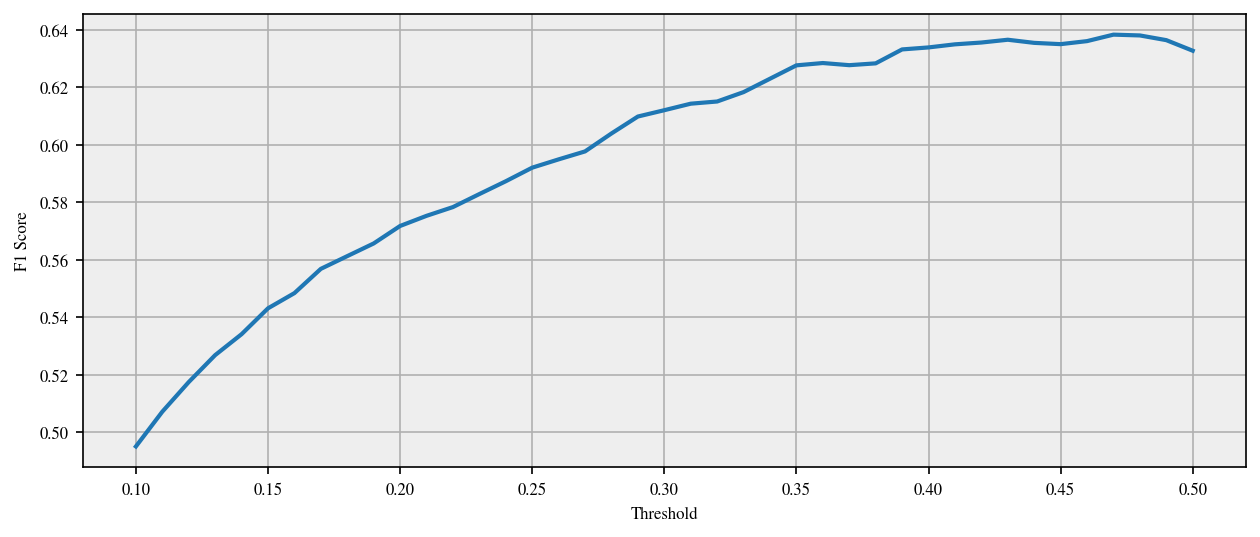

Fold: 1
Accuracy: 0.902241226776762
F1 Score: 0.6326869806094183
F1 Score with 0.4417500000000004 cutoff value 0.6370292887029289
AUC Score: 0.9371335029420722


0:	learn: 0.6627531	total: 28.9ms	remaining: 28.9s
1:	learn: 0.6337326	total: 52.7ms	remaining: 26.3s
2:	learn: 0.6082816	total: 82.7ms	remaining: 27.5s
3:	learn: 0.5866481	total: 107ms	remaining: 26.7s
4:	learn: 0.5667090	total: 129ms	remaining: 25.7s
5:	learn: 0.5487829	total: 151ms	remaining: 25s
6:	learn: 0.5327023	total: 170ms	remaining: 24.1s
7:	learn: 0.5174829	total: 185ms	remaining: 23s
8:	learn: 0.5042061	total: 200ms	remaining: 22s
9:	learn: 0.4923843	total: 216ms	remaining: 21.3s
10:	learn: 0.4812808	total: 229ms	remaining: 20.6s
11:	learn: 0.4710829	total: 241ms	remaining: 19.9s
12:	learn: 0.4612417	total: 253ms	remaining: 19.2s
13:	learn: 0.4531123	total: 266ms	remaining: 18.7s
14:	learn: 0.4445469	total: 279ms	remaining: 18.3s
15:	learn: 0.4379276	total: 292ms	remaining: 18s
16:	learn: 0.4310854	total: 302ms	rem

159:	learn: 0.2880257	total: 2.18s	remaining: 11.4s
160:	learn: 0.2875622	total: 2.19s	remaining: 11.4s
161:	learn: 0.2873811	total: 2.2s	remaining: 11.4s
162:	learn: 0.2869843	total: 2.21s	remaining: 11.4s
163:	learn: 0.2868488	total: 2.23s	remaining: 11.4s
164:	learn: 0.2866415	total: 2.24s	remaining: 11.3s
165:	learn: 0.2863996	total: 2.25s	remaining: 11.3s
166:	learn: 0.2861615	total: 2.27s	remaining: 11.3s
167:	learn: 0.2860014	total: 2.28s	remaining: 11.3s
168:	learn: 0.2857527	total: 2.29s	remaining: 11.2s
169:	learn: 0.2853522	total: 2.3s	remaining: 11.2s
170:	learn: 0.2851244	total: 2.31s	remaining: 11.2s
171:	learn: 0.2848678	total: 2.32s	remaining: 11.2s
172:	learn: 0.2845715	total: 2.33s	remaining: 11.2s
173:	learn: 0.2844238	total: 2.34s	remaining: 11.1s
174:	learn: 0.2842609	total: 2.35s	remaining: 11.1s
175:	learn: 0.2840259	total: 2.36s	remaining: 11.1s
176:	learn: 0.2838568	total: 2.38s	remaining: 11.1s
177:	learn: 0.2837226	total: 2.39s	remaining: 11s
178:	learn: 0.28

323:	learn: 0.2578208	total: 4.31s	remaining: 8.99s
324:	learn: 0.2577406	total: 4.32s	remaining: 8.98s
325:	learn: 0.2575652	total: 4.33s	remaining: 8.96s
326:	learn: 0.2574510	total: 4.35s	remaining: 8.95s
327:	learn: 0.2573205	total: 4.36s	remaining: 8.93s
328:	learn: 0.2572298	total: 4.37s	remaining: 8.91s
329:	learn: 0.2571464	total: 4.38s	remaining: 8.89s
330:	learn: 0.2569598	total: 4.39s	remaining: 8.87s
331:	learn: 0.2568381	total: 4.4s	remaining: 8.86s
332:	learn: 0.2564321	total: 4.41s	remaining: 8.84s
333:	learn: 0.2562376	total: 4.43s	remaining: 8.83s
334:	learn: 0.2560972	total: 4.43s	remaining: 8.8s
335:	learn: 0.2560106	total: 4.45s	remaining: 8.8s
336:	learn: 0.2558929	total: 4.46s	remaining: 8.78s
337:	learn: 0.2557920	total: 4.47s	remaining: 8.77s
338:	learn: 0.2556427	total: 4.5s	remaining: 8.77s
339:	learn: 0.2555024	total: 4.51s	remaining: 8.75s
340:	learn: 0.2552808	total: 4.52s	remaining: 8.74s
341:	learn: 0.2551605	total: 4.53s	remaining: 8.72s
342:	learn: 0.25

496:	learn: 0.2362319	total: 6.45s	remaining: 6.53s
497:	learn: 0.2360526	total: 6.46s	remaining: 6.51s
498:	learn: 0.2359689	total: 6.47s	remaining: 6.5s
499:	learn: 0.2358253	total: 6.49s	remaining: 6.49s
500:	learn: 0.2357366	total: 6.5s	remaining: 6.47s
501:	learn: 0.2355879	total: 6.52s	remaining: 6.46s
502:	learn: 0.2354464	total: 6.53s	remaining: 6.45s
503:	learn: 0.2353182	total: 6.55s	remaining: 6.44s
504:	learn: 0.2352137	total: 6.57s	remaining: 6.43s
505:	learn: 0.2351057	total: 6.58s	remaining: 6.42s
506:	learn: 0.2350446	total: 6.59s	remaining: 6.41s
507:	learn: 0.2349787	total: 6.6s	remaining: 6.39s
508:	learn: 0.2348793	total: 6.61s	remaining: 6.38s
509:	learn: 0.2347876	total: 6.63s	remaining: 6.37s
510:	learn: 0.2347132	total: 6.64s	remaining: 6.35s
511:	learn: 0.2346645	total: 6.65s	remaining: 6.34s
512:	learn: 0.2345758	total: 6.66s	remaining: 6.32s
513:	learn: 0.2344866	total: 6.67s	remaining: 6.31s
514:	learn: 0.2343657	total: 6.68s	remaining: 6.29s
515:	learn: 0.2

665:	learn: 0.2180283	total: 8.58s	remaining: 4.3s
666:	learn: 0.2179169	total: 8.59s	remaining: 4.29s
667:	learn: 0.2177889	total: 8.61s	remaining: 4.28s
668:	learn: 0.2177089	total: 8.62s	remaining: 4.26s
669:	learn: 0.2176677	total: 8.63s	remaining: 4.25s
670:	learn: 0.2176177	total: 8.64s	remaining: 4.24s
671:	learn: 0.2174329	total: 8.66s	remaining: 4.22s
672:	learn: 0.2173519	total: 8.67s	remaining: 4.21s
673:	learn: 0.2172272	total: 8.68s	remaining: 4.2s
674:	learn: 0.2171933	total: 8.69s	remaining: 4.18s
675:	learn: 0.2170403	total: 8.7s	remaining: 4.17s
676:	learn: 0.2169731	total: 8.71s	remaining: 4.16s
677:	learn: 0.2168535	total: 8.73s	remaining: 4.14s
678:	learn: 0.2167802	total: 8.74s	remaining: 4.13s
679:	learn: 0.2166550	total: 8.75s	remaining: 4.12s
680:	learn: 0.2165839	total: 8.76s	remaining: 4.11s
681:	learn: 0.2165202	total: 8.78s	remaining: 4.09s
682:	learn: 0.2164273	total: 8.79s	remaining: 4.08s
683:	learn: 0.2163228	total: 8.8s	remaining: 4.06s
684:	learn: 0.21

830:	learn: 0.2034546	total: 10.6s	remaining: 2.17s
831:	learn: 0.2034106	total: 10.7s	remaining: 2.15s
832:	learn: 0.2033222	total: 10.7s	remaining: 2.14s
833:	learn: 0.2031596	total: 10.7s	remaining: 2.13s
834:	learn: 0.2030625	total: 10.7s	remaining: 2.12s
835:	learn: 0.2030068	total: 10.7s	remaining: 2.1s
836:	learn: 0.2028799	total: 10.7s	remaining: 2.09s
837:	learn: 0.2028037	total: 10.7s	remaining: 2.08s
838:	learn: 0.2026817	total: 10.8s	remaining: 2.06s
839:	learn: 0.2025646	total: 10.8s	remaining: 2.05s
840:	learn: 0.2024296	total: 10.8s	remaining: 2.04s
841:	learn: 0.2023874	total: 10.8s	remaining: 2.02s
842:	learn: 0.2022965	total: 10.8s	remaining: 2.01s
843:	learn: 0.2022111	total: 10.8s	remaining: 2s
844:	learn: 0.2021546	total: 10.8s	remaining: 1.99s
845:	learn: 0.2021008	total: 10.8s	remaining: 1.97s
846:	learn: 0.2020020	total: 10.9s	remaining: 1.96s
847:	learn: 0.2019120	total: 10.9s	remaining: 1.95s
848:	learn: 0.2018122	total: 10.9s	remaining: 1.93s
849:	learn: 0.20

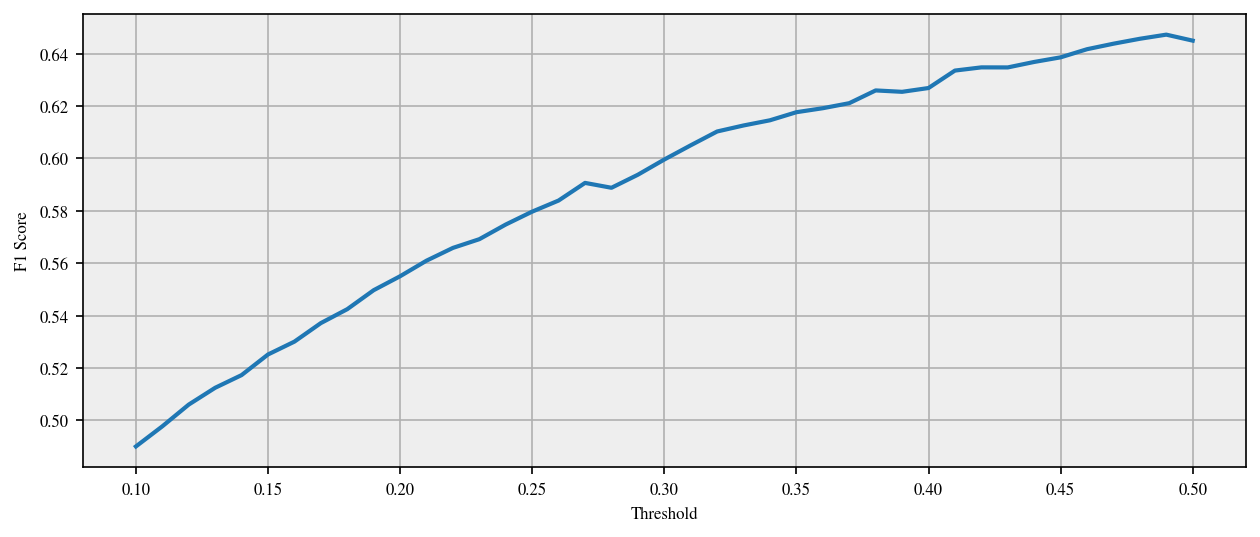

Fold: 2
Accuracy: 0.9019463285166618
F1 Score: 0.6449546182594768
F1 Score with 0.4922500000000005 cutoff value 0.6482758620689655
AUC Score: 0.9360744999655062


0:	learn: 0.6602158	total: 31.6ms	remaining: 31.6s
1:	learn: 0.6323532	total: 55.3ms	remaining: 27.6s
2:	learn: 0.6074393	total: 77.7ms	remaining: 25.8s
3:	learn: 0.5845355	total: 103ms	remaining: 25.6s
4:	learn: 0.5641068	total: 126ms	remaining: 25s
5:	learn: 0.5460708	total: 149ms	remaining: 24.6s
6:	learn: 0.5290005	total: 166ms	remaining: 23.5s
7:	learn: 0.5157644	total: 179ms	remaining: 22.2s
8:	learn: 0.5016031	total: 191ms	remaining: 21s
9:	learn: 0.4893855	total: 204ms	remaining: 20.2s
10:	learn: 0.4778656	total: 218ms	remaining: 19.6s
11:	learn: 0.4672193	total: 231ms	remaining: 19s
12:	learn: 0.4575751	total: 245ms	remaining: 18.6s
13:	learn: 0.4496728	total: 258ms	remaining: 18.2s
14:	learn: 0.4415360	total: 271ms	remaining: 17.8s
15:	learn: 0.4338111	total: 285ms	remaining: 17.5s
16:	learn: 0.4274214	total: 298ms	

165:	learn: 0.2831024	total: 2.34s	remaining: 11.8s
166:	learn: 0.2829714	total: 2.36s	remaining: 11.8s
167:	learn: 0.2828253	total: 2.37s	remaining: 11.7s
168:	learn: 0.2826619	total: 2.38s	remaining: 11.7s
169:	learn: 0.2824863	total: 2.39s	remaining: 11.7s
170:	learn: 0.2823423	total: 2.4s	remaining: 11.6s
171:	learn: 0.2821528	total: 2.41s	remaining: 11.6s
172:	learn: 0.2820411	total: 2.42s	remaining: 11.6s
173:	learn: 0.2818751	total: 2.44s	remaining: 11.6s
174:	learn: 0.2816888	total: 2.45s	remaining: 11.6s
175:	learn: 0.2814699	total: 2.47s	remaining: 11.6s
176:	learn: 0.2812586	total: 2.48s	remaining: 11.5s
177:	learn: 0.2810472	total: 2.5s	remaining: 11.5s
178:	learn: 0.2809202	total: 2.51s	remaining: 11.5s
179:	learn: 0.2807308	total: 2.52s	remaining: 11.5s
180:	learn: 0.2802953	total: 2.54s	remaining: 11.5s
181:	learn: 0.2798370	total: 2.56s	remaining: 11.5s
182:	learn: 0.2796868	total: 2.57s	remaining: 11.5s
183:	learn: 0.2794191	total: 2.58s	remaining: 11.5s
184:	learn: 0.

327:	learn: 0.2533253	total: 4.56s	remaining: 9.34s
328:	learn: 0.2531516	total: 4.57s	remaining: 9.32s
329:	learn: 0.2529846	total: 4.58s	remaining: 9.3s
330:	learn: 0.2529003	total: 4.6s	remaining: 9.29s
331:	learn: 0.2527016	total: 4.61s	remaining: 9.28s
332:	learn: 0.2525546	total: 4.63s	remaining: 9.27s
333:	learn: 0.2524154	total: 4.64s	remaining: 9.26s
334:	learn: 0.2520690	total: 4.65s	remaining: 9.24s
335:	learn: 0.2518738	total: 4.67s	remaining: 9.23s
336:	learn: 0.2516927	total: 4.68s	remaining: 9.21s
337:	learn: 0.2515887	total: 4.7s	remaining: 9.2s
338:	learn: 0.2514552	total: 4.71s	remaining: 9.19s
339:	learn: 0.2512709	total: 4.73s	remaining: 9.18s
340:	learn: 0.2508782	total: 4.74s	remaining: 9.16s
341:	learn: 0.2507568	total: 4.76s	remaining: 9.15s
342:	learn: 0.2505546	total: 4.77s	remaining: 9.14s
343:	learn: 0.2503151	total: 4.79s	remaining: 9.13s
344:	learn: 0.2497956	total: 4.8s	remaining: 9.11s
345:	learn: 0.2496520	total: 4.81s	remaining: 9.1s
346:	learn: 0.2494

492:	learn: 0.2316534	total: 7.11s	remaining: 7.31s
493:	learn: 0.2315479	total: 7.12s	remaining: 7.29s
494:	learn: 0.2314739	total: 7.13s	remaining: 7.28s
495:	learn: 0.2313332	total: 7.15s	remaining: 7.27s
496:	learn: 0.2312616	total: 7.18s	remaining: 7.26s
497:	learn: 0.2311421	total: 7.19s	remaining: 7.25s
498:	learn: 0.2310773	total: 7.21s	remaining: 7.24s
499:	learn: 0.2309705	total: 7.22s	remaining: 7.22s
500:	learn: 0.2308335	total: 7.23s	remaining: 7.2s
501:	learn: 0.2307569	total: 7.25s	remaining: 7.19s
502:	learn: 0.2305567	total: 7.26s	remaining: 7.18s
503:	learn: 0.2303230	total: 7.28s	remaining: 7.17s
504:	learn: 0.2301991	total: 7.3s	remaining: 7.15s
505:	learn: 0.2300760	total: 7.31s	remaining: 7.14s
506:	learn: 0.2300076	total: 7.32s	remaining: 7.12s
507:	learn: 0.2298950	total: 7.33s	remaining: 7.1s
508:	learn: 0.2298038	total: 7.34s	remaining: 7.08s
509:	learn: 0.2297234	total: 7.36s	remaining: 7.07s
510:	learn: 0.2296503	total: 7.39s	remaining: 7.07s
511:	learn: 0.2

662:	learn: 0.2143648	total: 9.54s	remaining: 4.85s
663:	learn: 0.2142813	total: 9.55s	remaining: 4.83s
664:	learn: 0.2141479	total: 9.56s	remaining: 4.82s
665:	learn: 0.2140640	total: 9.58s	remaining: 4.8s
666:	learn: 0.2139833	total: 9.59s	remaining: 4.79s
667:	learn: 0.2138646	total: 9.61s	remaining: 4.77s
668:	learn: 0.2137992	total: 9.62s	remaining: 4.76s
669:	learn: 0.2137424	total: 9.63s	remaining: 4.75s
670:	learn: 0.2136776	total: 9.65s	remaining: 4.73s
671:	learn: 0.2135828	total: 9.66s	remaining: 4.71s
672:	learn: 0.2134791	total: 9.67s	remaining: 4.7s
673:	learn: 0.2134055	total: 9.69s	remaining: 4.69s
674:	learn: 0.2133563	total: 9.7s	remaining: 4.67s
675:	learn: 0.2132063	total: 9.72s	remaining: 4.66s
676:	learn: 0.2130866	total: 9.73s	remaining: 4.64s
677:	learn: 0.2129588	total: 9.74s	remaining: 4.63s
678:	learn: 0.2128247	total: 9.76s	remaining: 4.61s
679:	learn: 0.2127416	total: 9.78s	remaining: 4.6s
680:	learn: 0.2126840	total: 9.79s	remaining: 4.58s
681:	learn: 0.21

828:	learn: 0.1997002	total: 11.8s	remaining: 2.44s
829:	learn: 0.1996318	total: 11.8s	remaining: 2.42s
830:	learn: 0.1995580	total: 11.8s	remaining: 2.41s
831:	learn: 0.1995084	total: 11.9s	remaining: 2.39s
832:	learn: 0.1994577	total: 11.9s	remaining: 2.38s
833:	learn: 0.1993551	total: 11.9s	remaining: 2.37s
834:	learn: 0.1992607	total: 11.9s	remaining: 2.35s
835:	learn: 0.1991922	total: 11.9s	remaining: 2.34s
836:	learn: 0.1991462	total: 11.9s	remaining: 2.32s
837:	learn: 0.1990226	total: 11.9s	remaining: 2.31s
838:	learn: 0.1988824	total: 11.9s	remaining: 2.29s
839:	learn: 0.1988464	total: 12s	remaining: 2.28s
840:	learn: 0.1987697	total: 12s	remaining: 2.26s
841:	learn: 0.1986961	total: 12s	remaining: 2.25s
842:	learn: 0.1986032	total: 12s	remaining: 2.23s
843:	learn: 0.1985095	total: 12s	remaining: 2.22s
844:	learn: 0.1983891	total: 12s	remaining: 2.21s
845:	learn: 0.1983281	total: 12s	remaining: 2.19s
846:	learn: 0.1982538	total: 12.1s	remaining: 2.18s
847:	learn: 0.1982156	tota

988:	learn: 0.1873487	total: 14s	remaining: 156ms
989:	learn: 0.1872221	total: 14s	remaining: 141ms
990:	learn: 0.1871743	total: 14s	remaining: 127ms
991:	learn: 0.1871099	total: 14s	remaining: 113ms
992:	learn: 0.1870195	total: 14s	remaining: 99ms
993:	learn: 0.1869449	total: 14.1s	remaining: 84.8ms
994:	learn: 0.1868754	total: 14.1s	remaining: 70.7ms
995:	learn: 0.1867774	total: 14.1s	remaining: 56.6ms
996:	learn: 0.1867089	total: 14.1s	remaining: 42.4ms
997:	learn: 0.1866481	total: 14.1s	remaining: 28.3ms
998:	learn: 0.1865205	total: 14.1s	remaining: 14.1ms
999:	learn: 0.1864440	total: 14.1s	remaining: 0us


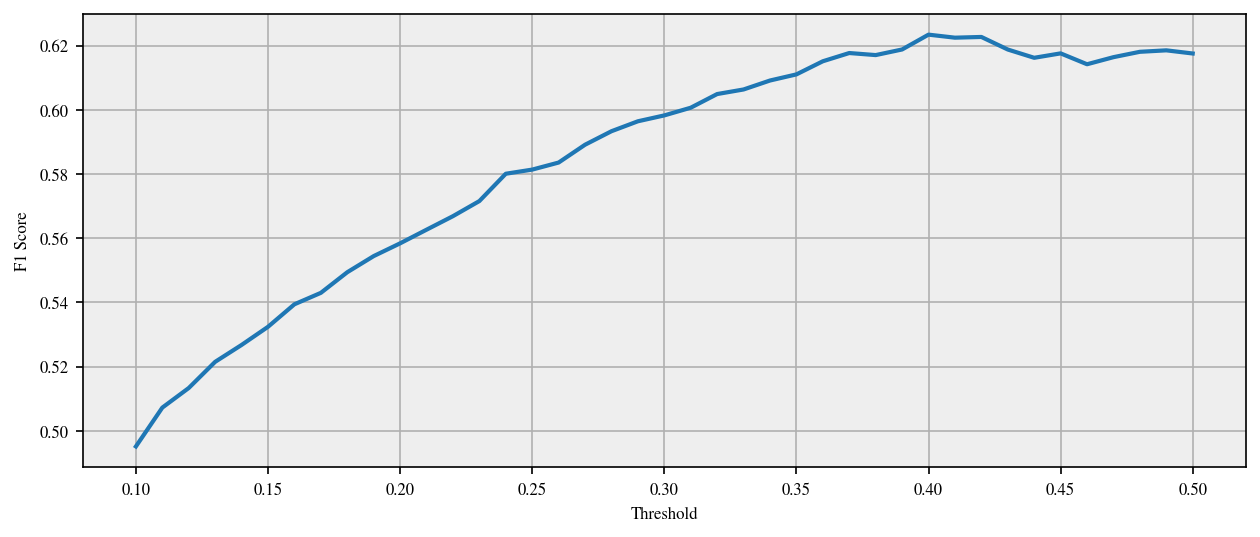

Fold: 3
Accuracy: 0.8982601002654085
F1 Score: 0.6175166297117516
F1 Score with 0.40225000000000044 cutoff value 0.624627606752731
AUC Score: 0.9289243394310334


0:	learn: 0.6605584	total: 49.6ms	remaining: 49.6s
1:	learn: 0.6332991	total: 69ms	remaining: 34.4s
2:	learn: 0.6076733	total: 88.9ms	remaining: 29.5s
3:	learn: 0.5859104	total: 111ms	remaining: 27.5s
4:	learn: 0.5656669	total: 130ms	remaining: 25.9s
5:	learn: 0.5484947	total: 152ms	remaining: 25.3s
6:	learn: 0.5319922	total: 170ms	remaining: 24.2s
7:	learn: 0.5176390	total: 184ms	remaining: 22.9s
8:	learn: 0.5040219	total: 200ms	remaining: 22s
9:	learn: 0.4908630	total: 213ms	remaining: 21.1s
10:	learn: 0.4786202	total: 225ms	remaining: 20.2s
11:	learn: 0.4683723	total: 235ms	remaining: 19.3s
12:	learn: 0.4582960	total: 243ms	remaining: 18.5s
13:	learn: 0.4498226	total: 254ms	remaining: 17.9s
14:	learn: 0.4419438	total: 269ms	remaining: 17.6s
15:	learn: 0.4347590	total: 281ms	remaining: 17.3s
16:	learn: 0.4285541	total: 294m

159:	learn: 0.2859190	total: 2.18s	remaining: 11.4s
160:	learn: 0.2857400	total: 2.19s	remaining: 11.4s
161:	learn: 0.2855949	total: 2.2s	remaining: 11.4s
162:	learn: 0.2853772	total: 2.22s	remaining: 11.4s
163:	learn: 0.2851642	total: 2.23s	remaining: 11.4s
164:	learn: 0.2850206	total: 2.25s	remaining: 11.4s
165:	learn: 0.2846484	total: 2.26s	remaining: 11.3s
166:	learn: 0.2843383	total: 2.27s	remaining: 11.3s
167:	learn: 0.2841322	total: 2.29s	remaining: 11.3s
168:	learn: 0.2840082	total: 2.3s	remaining: 11.3s
169:	learn: 0.2837168	total: 2.31s	remaining: 11.3s
170:	learn: 0.2835280	total: 2.33s	remaining: 11.3s
171:	learn: 0.2830122	total: 2.34s	remaining: 11.3s
172:	learn: 0.2828518	total: 2.36s	remaining: 11.3s
173:	learn: 0.2827147	total: 2.37s	remaining: 11.3s
174:	learn: 0.2825269	total: 2.39s	remaining: 11.2s
175:	learn: 0.2823803	total: 2.4s	remaining: 11.2s
176:	learn: 0.2821516	total: 2.41s	remaining: 11.2s
177:	learn: 0.2818918	total: 2.43s	remaining: 11.2s
178:	learn: 0.2

319:	learn: 0.2537854	total: 4.33s	remaining: 9.21s
320:	learn: 0.2536186	total: 4.35s	remaining: 9.2s
321:	learn: 0.2535373	total: 4.36s	remaining: 9.19s
322:	learn: 0.2534501	total: 4.38s	remaining: 9.17s
323:	learn: 0.2533412	total: 4.39s	remaining: 9.16s
324:	learn: 0.2532465	total: 4.41s	remaining: 9.15s
325:	learn: 0.2530273	total: 4.42s	remaining: 9.14s
326:	learn: 0.2529274	total: 4.43s	remaining: 9.13s
327:	learn: 0.2528056	total: 4.45s	remaining: 9.11s
328:	learn: 0.2526460	total: 4.46s	remaining: 9.1s
329:	learn: 0.2524744	total: 4.47s	remaining: 9.08s
330:	learn: 0.2519323	total: 4.49s	remaining: 9.07s
331:	learn: 0.2517742	total: 4.5s	remaining: 9.05s
332:	learn: 0.2515252	total: 4.51s	remaining: 9.04s
333:	learn: 0.2511906	total: 4.52s	remaining: 9.02s
334:	learn: 0.2510755	total: 4.53s	remaining: 9s
335:	learn: 0.2508968	total: 4.54s	remaining: 8.98s
336:	learn: 0.2507883	total: 4.55s	remaining: 8.95s
337:	learn: 0.2507087	total: 4.56s	remaining: 8.93s
338:	learn: 0.2505

478:	learn: 0.2333248	total: 6.28s	remaining: 6.83s
479:	learn: 0.2331799	total: 6.29s	remaining: 6.82s
480:	learn: 0.2329975	total: 6.3s	remaining: 6.8s
481:	learn: 0.2328168	total: 6.32s	remaining: 6.79s
482:	learn: 0.2326891	total: 6.33s	remaining: 6.78s
483:	learn: 0.2325956	total: 6.34s	remaining: 6.76s
484:	learn: 0.2324831	total: 6.36s	remaining: 6.75s
485:	learn: 0.2324098	total: 6.37s	remaining: 6.74s
486:	learn: 0.2323426	total: 6.38s	remaining: 6.72s
487:	learn: 0.2322716	total: 6.4s	remaining: 6.71s
488:	learn: 0.2321189	total: 6.41s	remaining: 6.7s
489:	learn: 0.2320060	total: 6.42s	remaining: 6.69s
490:	learn: 0.2318423	total: 6.44s	remaining: 6.67s
491:	learn: 0.2316480	total: 6.45s	remaining: 6.66s
492:	learn: 0.2315443	total: 6.47s	remaining: 6.65s
493:	learn: 0.2314316	total: 6.48s	remaining: 6.64s
494:	learn: 0.2313279	total: 6.5s	remaining: 6.63s
495:	learn: 0.2311790	total: 6.51s	remaining: 6.62s
496:	learn: 0.2310322	total: 6.52s	remaining: 6.6s
497:	learn: 0.2309

648:	learn: 0.2151889	total: 8.58s	remaining: 4.64s
649:	learn: 0.2150985	total: 8.59s	remaining: 4.63s
650:	learn: 0.2149931	total: 8.6s	remaining: 4.61s
651:	learn: 0.2148881	total: 8.61s	remaining: 4.6s
652:	learn: 0.2148499	total: 8.63s	remaining: 4.58s
653:	learn: 0.2147662	total: 8.64s	remaining: 4.57s
654:	learn: 0.2146130	total: 8.65s	remaining: 4.56s
655:	learn: 0.2145703	total: 8.67s	remaining: 4.54s
656:	learn: 0.2144905	total: 8.68s	remaining: 4.53s
657:	learn: 0.2144185	total: 8.7s	remaining: 4.52s
658:	learn: 0.2142919	total: 8.71s	remaining: 4.5s
659:	learn: 0.2141914	total: 8.72s	remaining: 4.49s
660:	learn: 0.2141116	total: 8.73s	remaining: 4.48s
661:	learn: 0.2140133	total: 8.75s	remaining: 4.47s
662:	learn: 0.2138949	total: 8.76s	remaining: 4.45s
663:	learn: 0.2138256	total: 8.77s	remaining: 4.44s
664:	learn: 0.2136891	total: 8.78s	remaining: 4.42s
665:	learn: 0.2136144	total: 8.8s	remaining: 4.41s
666:	learn: 0.2135647	total: 8.81s	remaining: 4.4s
667:	learn: 0.2134

815:	learn: 0.2006919	total: 10.9s	remaining: 2.46s
816:	learn: 0.2006064	total: 10.9s	remaining: 2.44s
817:	learn: 0.2005417	total: 10.9s	remaining: 2.43s
818:	learn: 0.2004863	total: 10.9s	remaining: 2.42s
819:	learn: 0.2004278	total: 10.9s	remaining: 2.4s
820:	learn: 0.2002971	total: 10.9s	remaining: 2.39s
821:	learn: 0.2002120	total: 11s	remaining: 2.37s
822:	learn: 0.2001470	total: 11s	remaining: 2.36s
823:	learn: 0.2000198	total: 11s	remaining: 2.34s
824:	learn: 0.1999663	total: 11s	remaining: 2.33s
825:	learn: 0.1999295	total: 11s	remaining: 2.32s
826:	learn: 0.1998743	total: 11s	remaining: 2.3s
827:	learn: 0.1997333	total: 11s	remaining: 2.29s
828:	learn: 0.1996563	total: 11s	remaining: 2.28s
829:	learn: 0.1996111	total: 11s	remaining: 2.26s
830:	learn: 0.1995185	total: 11.1s	remaining: 2.25s
831:	learn: 0.1994613	total: 11.1s	remaining: 2.23s
832:	learn: 0.1994136	total: 11.1s	remaining: 2.22s
833:	learn: 0.1993570	total: 11.1s	remaining: 2.21s
834:	learn: 0.1992768	total: 11.

974:	learn: 0.1880272	total: 13s	remaining: 334ms
975:	learn: 0.1878500	total: 13s	remaining: 321ms
976:	learn: 0.1877696	total: 13.1s	remaining: 307ms
977:	learn: 0.1877262	total: 13.1s	remaining: 294ms
978:	learn: 0.1876494	total: 13.1s	remaining: 281ms
979:	learn: 0.1875329	total: 13.1s	remaining: 267ms
980:	learn: 0.1874103	total: 13.1s	remaining: 254ms
981:	learn: 0.1872653	total: 13.1s	remaining: 241ms
982:	learn: 0.1871743	total: 13.1s	remaining: 227ms
983:	learn: 0.1871116	total: 13.1s	remaining: 214ms
984:	learn: 0.1870728	total: 13.2s	remaining: 200ms
985:	learn: 0.1869707	total: 13.2s	remaining: 187ms
986:	learn: 0.1869178	total: 13.2s	remaining: 174ms
987:	learn: 0.1868795	total: 13.2s	remaining: 160ms
988:	learn: 0.1868233	total: 13.2s	remaining: 147ms
989:	learn: 0.1867658	total: 13.2s	remaining: 134ms
990:	learn: 0.1866876	total: 13.2s	remaining: 120ms
991:	learn: 0.1866272	total: 13.3s	remaining: 107ms
992:	learn: 0.1865381	total: 13.3s	remaining: 93.5ms
993:	learn: 0.1

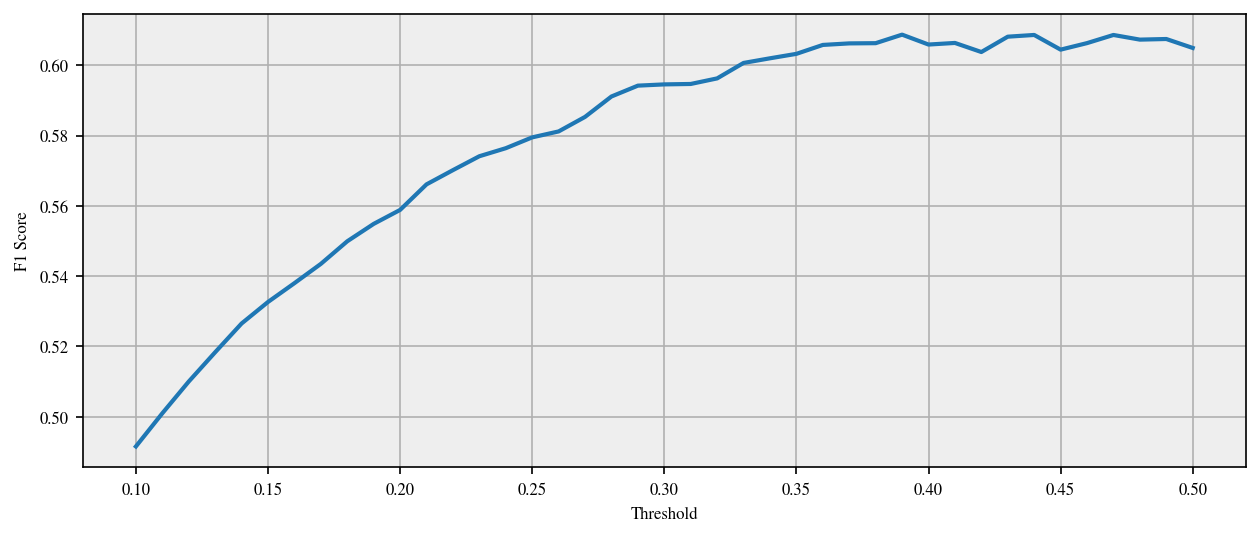

Fold: 4
Accuracy: 0.8955906208523816
F1 Score: 0.6049107142857142
F1 Score with 0.4697500000000005 cutoff value 0.6086021505376344
AUC Score: 0.9286359604454811


0:	learn: 0.6616957	total: 33.2ms	remaining: 33.2s
1:	learn: 0.6326181	total: 96.7ms	remaining: 48.3s
2:	learn: 0.6067053	total: 155ms	remaining: 51.4s
3:	learn: 0.5846352	total: 184ms	remaining: 45.8s
4:	learn: 0.5636476	total: 198ms	remaining: 39.3s
5:	learn: 0.5463311	total: 211ms	remaining: 35s
6:	learn: 0.5296566	total: 230ms	remaining: 32.7s
7:	learn: 0.5150502	total: 247ms	remaining: 30.6s
8:	learn: 0.5018439	total: 264ms	remaining: 29.1s
9:	learn: 0.4898683	total: 279ms	remaining: 27.6s
10:	learn: 0.4789604	total: 294ms	remaining: 26.4s
11:	learn: 0.4692823	total: 307ms	remaining: 25.3s
12:	learn: 0.4598847	total: 323ms	remaining: 24.5s
13:	learn: 0.4515203	total: 339ms	remaining: 23.9s
14:	learn: 0.4432637	total: 355ms	remaining: 23.3s
15:	learn: 0.4362443	total: 370ms	remaining: 22.7s
16:	learn: 0.4296061	total: 385

158:	learn: 0.2869085	total: 2.35s	remaining: 12.5s
159:	learn: 0.2865335	total: 2.37s	remaining: 12.4s
160:	learn: 0.2863251	total: 2.38s	remaining: 12.4s
161:	learn: 0.2861719	total: 2.39s	remaining: 12.3s
162:	learn: 0.2860010	total: 2.4s	remaining: 12.3s
163:	learn: 0.2857117	total: 2.41s	remaining: 12.3s
164:	learn: 0.2853615	total: 2.43s	remaining: 12.3s
165:	learn: 0.2850110	total: 2.44s	remaining: 12.3s
166:	learn: 0.2848203	total: 2.46s	remaining: 12.2s
167:	learn: 0.2847118	total: 2.47s	remaining: 12.2s
168:	learn: 0.2840989	total: 2.49s	remaining: 12.2s
169:	learn: 0.2839251	total: 2.5s	remaining: 12.2s
170:	learn: 0.2833186	total: 2.51s	remaining: 12.2s
171:	learn: 0.2831833	total: 2.53s	remaining: 12.2s
172:	learn: 0.2828612	total: 2.54s	remaining: 12.1s
173:	learn: 0.2826877	total: 2.55s	remaining: 12.1s
174:	learn: 0.2825567	total: 2.57s	remaining: 12.1s
175:	learn: 0.2824399	total: 2.59s	remaining: 12.1s
176:	learn: 0.2822787	total: 2.61s	remaining: 12.1s
177:	learn: 0.

326:	learn: 0.2558537	total: 4.71s	remaining: 9.69s
327:	learn: 0.2557435	total: 4.72s	remaining: 9.68s
328:	learn: 0.2555616	total: 4.74s	remaining: 9.66s
329:	learn: 0.2552957	total: 4.75s	remaining: 9.64s
330:	learn: 0.2551917	total: 4.76s	remaining: 9.62s
331:	learn: 0.2550852	total: 4.78s	remaining: 9.61s
332:	learn: 0.2549525	total: 4.79s	remaining: 9.59s
333:	learn: 0.2548064	total: 4.8s	remaining: 9.56s
334:	learn: 0.2546705	total: 4.81s	remaining: 9.55s
335:	learn: 0.2545327	total: 4.83s	remaining: 9.54s
336:	learn: 0.2543766	total: 4.84s	remaining: 9.52s
337:	learn: 0.2542748	total: 4.85s	remaining: 9.5s
338:	learn: 0.2540827	total: 4.87s	remaining: 9.49s
339:	learn: 0.2539783	total: 4.88s	remaining: 9.47s
340:	learn: 0.2538306	total: 4.89s	remaining: 9.45s
341:	learn: 0.2537129	total: 4.9s	remaining: 9.44s
342:	learn: 0.2536164	total: 4.92s	remaining: 9.42s
343:	learn: 0.2534533	total: 4.93s	remaining: 9.41s
344:	learn: 0.2533587	total: 4.95s	remaining: 9.39s
345:	learn: 0.2

498:	learn: 0.2340328	total: 7.01s	remaining: 7.04s
499:	learn: 0.2339442	total: 7.02s	remaining: 7.02s
500:	learn: 0.2337618	total: 7.03s	remaining: 7s
501:	learn: 0.2336720	total: 7.04s	remaining: 6.99s
502:	learn: 0.2336024	total: 7.06s	remaining: 6.97s
503:	learn: 0.2335311	total: 7.07s	remaining: 6.95s
504:	learn: 0.2334655	total: 7.08s	remaining: 6.94s
505:	learn: 0.2334065	total: 7.1s	remaining: 6.93s
506:	learn: 0.2333299	total: 7.11s	remaining: 6.91s
507:	learn: 0.2332632	total: 7.12s	remaining: 6.9s
508:	learn: 0.2331598	total: 7.13s	remaining: 6.88s
509:	learn: 0.2330890	total: 7.15s	remaining: 6.87s
510:	learn: 0.2329816	total: 7.16s	remaining: 6.85s
511:	learn: 0.2329014	total: 7.17s	remaining: 6.84s
512:	learn: 0.2328359	total: 7.19s	remaining: 6.82s
513:	learn: 0.2327506	total: 7.2s	remaining: 6.81s
514:	learn: 0.2325545	total: 7.21s	remaining: 6.79s
515:	learn: 0.2324876	total: 7.22s	remaining: 6.78s
516:	learn: 0.2324263	total: 7.24s	remaining: 6.76s
517:	learn: 0.2323

657:	learn: 0.2178288	total: 8.97s	remaining: 4.66s
658:	learn: 0.2177520	total: 8.97s	remaining: 4.64s
659:	learn: 0.2175948	total: 8.99s	remaining: 4.63s
660:	learn: 0.2175240	total: 9s	remaining: 4.62s
661:	learn: 0.2174512	total: 9.01s	remaining: 4.6s
662:	learn: 0.2173762	total: 9.03s	remaining: 4.59s
663:	learn: 0.2173163	total: 9.04s	remaining: 4.57s
664:	learn: 0.2172161	total: 9.05s	remaining: 4.56s
665:	learn: 0.2171196	total: 9.07s	remaining: 4.55s
666:	learn: 0.2170031	total: 9.08s	remaining: 4.53s
667:	learn: 0.2169596	total: 9.09s	remaining: 4.52s
668:	learn: 0.2168923	total: 9.11s	remaining: 4.51s
669:	learn: 0.2167716	total: 9.12s	remaining: 4.49s
670:	learn: 0.2166932	total: 9.13s	remaining: 4.48s
671:	learn: 0.2165940	total: 9.15s	remaining: 4.46s
672:	learn: 0.2165313	total: 9.17s	remaining: 4.45s
673:	learn: 0.2164393	total: 9.18s	remaining: 4.44s
674:	learn: 0.2163222	total: 9.19s	remaining: 4.42s
675:	learn: 0.2162453	total: 9.2s	remaining: 4.41s
676:	learn: 0.216

824:	learn: 0.2031955	total: 11s	remaining: 2.34s
825:	learn: 0.2031124	total: 11s	remaining: 2.32s
826:	learn: 0.2029433	total: 11s	remaining: 2.31s
827:	learn: 0.2028834	total: 11.1s	remaining: 2.29s
828:	learn: 0.2027914	total: 11.1s	remaining: 2.28s
829:	learn: 0.2027329	total: 11.1s	remaining: 2.27s
830:	learn: 0.2026865	total: 11.1s	remaining: 2.25s
831:	learn: 0.2026258	total: 11.1s	remaining: 2.24s
832:	learn: 0.2025769	total: 11.1s	remaining: 2.23s
833:	learn: 0.2025056	total: 11.1s	remaining: 2.21s
834:	learn: 0.2024235	total: 11.1s	remaining: 2.2s
835:	learn: 0.2023403	total: 11.1s	remaining: 2.19s
836:	learn: 0.2022318	total: 11.2s	remaining: 2.17s
837:	learn: 0.2021417	total: 11.2s	remaining: 2.16s
838:	learn: 0.2020931	total: 11.2s	remaining: 2.15s
839:	learn: 0.2019893	total: 11.2s	remaining: 2.13s
840:	learn: 0.2019318	total: 11.2s	remaining: 2.12s
841:	learn: 0.2018758	total: 11.2s	remaining: 2.1s
842:	learn: 0.2017898	total: 11.2s	remaining: 2.09s
843:	learn: 0.201601

986:	learn: 0.1910434	total: 13s	remaining: 171ms
987:	learn: 0.1909591	total: 13s	remaining: 158ms
988:	learn: 0.1909248	total: 13s	remaining: 145ms
989:	learn: 0.1908424	total: 13s	remaining: 132ms
990:	learn: 0.1907750	total: 13s	remaining: 118ms
991:	learn: 0.1906642	total: 13.1s	remaining: 105ms
992:	learn: 0.1906119	total: 13.1s	remaining: 92.2ms
993:	learn: 0.1905412	total: 13.1s	remaining: 79ms
994:	learn: 0.1905206	total: 13.1s	remaining: 65.8ms
995:	learn: 0.1904378	total: 13.1s	remaining: 52.6ms
996:	learn: 0.1903535	total: 13.1s	remaining: 39.5ms
997:	learn: 0.1903128	total: 13.1s	remaining: 26.3ms
998:	learn: 0.1902435	total: 13.1s	remaining: 13.2ms
999:	learn: 0.1901858	total: 13.2s	remaining: 0us


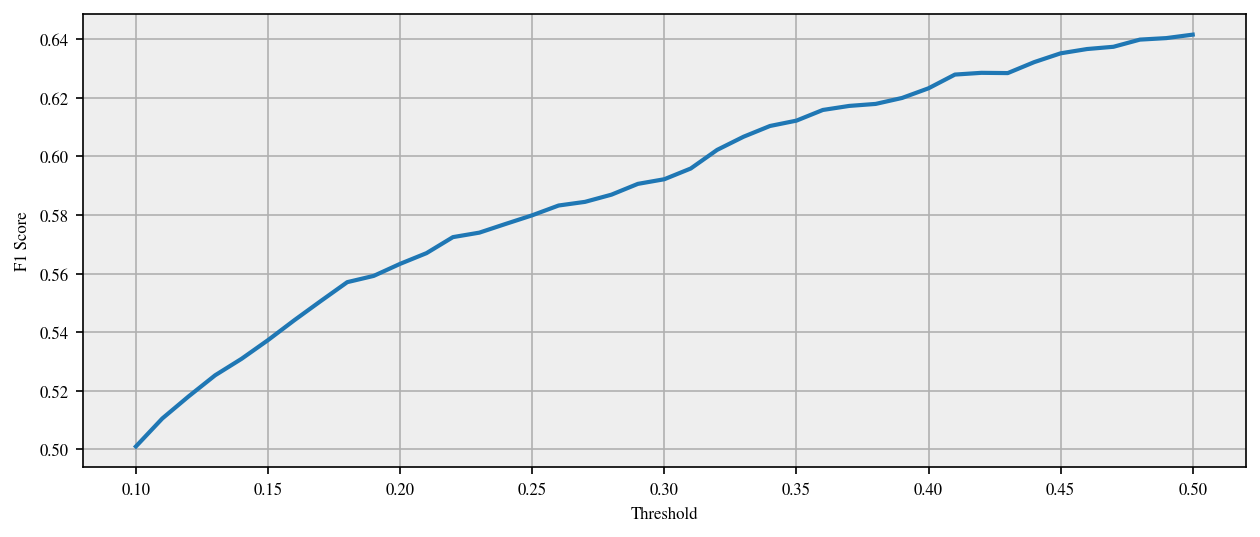

Fold: 5
Accuracy: 0.902964164577496
F1 Score: 0.6416122004357299
F1 Score with 0.5477500000000005 cutoff value 0.6456059735784032
AUC Score: 0.9378325798296889




In [28]:
from sklearn.model_selection import KFold, StratifiedKFold

from scipy.optimize import fmin 

    
err_vote_ac = []
err_vote_f1 = []
err_vote_f1_c = []
err_vote_auc = []

y_pred_tot_vote = []
y_pred_tot_vote_c = []
y_pred_tot_vote_prob = []

cutoff_value = []
feature_importance_df = pd.DataFrame()

fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
i = 1
f = 0
for train_index, test_index in fold.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    m = VotingClassifier(
    estimators=[
                ('ct',cat_model),
                ('xg',xgb_model),
                ('lg',lgb_model)
    ],
    voting='soft')
    
    m.fit(X_train, y_train)

    y_pred = m.predict(X_test)
    y_pred_prob = m.predict_proba(X_test)[:,1]
    
    test_pred = m.predict(test_X)
    test_pred_proba = m.predict_proba(test_X)[:,1]
    
    threshold = []
    score = []
    for thresh in np.arange(0.1, 0.501, 0.01):
        thresh = np.round(thresh, 2)
        threshold.append(thresh)
        score.append(f1_score(y_test, (y_pred_prob>thresh).astype(int)))
        
    sns.lineplot(x=threshold, y=score)
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.show()
    
    def minus_f_score(cutoff):
        if (cutoff < 0) or (cutoff > 1):
            return np.inf
        else:
            return - 1* f1_score(y_test, 1 * (y_pred_prob > cutoff)) 
    
    cutoff_null = [0]
    cut_f_min = fmin(minus_f_score, cutoff_null, disp=False)
    
    if cut_f_min[0] ==0:
        cut = 0.5
    else:
        cut = cut_f_min[0]
    
    cutoff_value.append(cut)    
    err_ac = accuracy_score(y_test, y_pred)
    err_f1 = f1_score(y_test, y_pred)
    err_f1_c = f1_score(y_test, (y_pred_prob>cut).astype(int))
    err_auc = roc_auc_score(y_test, y_pred_prob)
    
    
    f += 1
    print("Fold:", f)
    print("Accuracy:", err_ac)
    print('F1 Score:', err_f1)
    print('F1 Score with {} cutoff value {}'.format(cut, err_f1_c))
    print("AUC Score:", err_auc)
    print('\n')
    
    err_vote_ac.append(err_ac)
    err_vote_f1.append(err_f1)
    err_vote_f1_c.append(err_f1_c)
    err_vote_auc.append(err_auc)
    
    y_pred_tot_vote.append(test_pred)
    y_pred_tot_vote_c.append((test_pred_proba>cut).astype(int))
    y_pred_tot_vote_prob.append(test_pred_proba)
    

In [29]:
print(np.mean(err_vote_f1), np.std(err_vote_f1))
print(np.mean(err_vote_f1_c), np.std(err_vote_f1_c))

0.628336228660418 0.015080913679854742
0.6328281763281327 0.014654024085315987


In [30]:
vote_thresh = np.mean(cutoff_value)
print(vote_thresh)

vote_test_pred1 = np.mean(y_pred_tot_vote, 0).round().astype(int)
vote_test_pred2 = np.mean(y_pred_tot_vote_c, 0).round().astype(int)
vote_test_pred3 = (np.mean(y_pred_tot_vote_prob, 0)>vote_thresh).astype(int)

0.4707500000000005


In [32]:
sample['labels'] = vote_test_pred2
print(sample['labels'].value_counts())
sample.to_excel(path+'vote_5_fold_2.xlsx', index=False) #0.64025

0    9481
1    1822
Name: labels, dtype: int64
